Code based on: https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7/

Related blog explaining LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
#CPU Information
!lscpu

Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:              6
    Model:                   85
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                3
    BogoMIPS:                4000.35
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

In [ ]:
#GPU Information
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-815ce8a4-7c1a-b1cb-8c82-706a992fc971)


In [1]:
import numpy as np

N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1) # add random offset (column vector of size N) to each sample (row vector of size L), resulting in matrix of size (N,L)
y = np.sin(x/1.0/T).astype(np.float32)

In [2]:
y.shape # N x L 

(100, 1000)

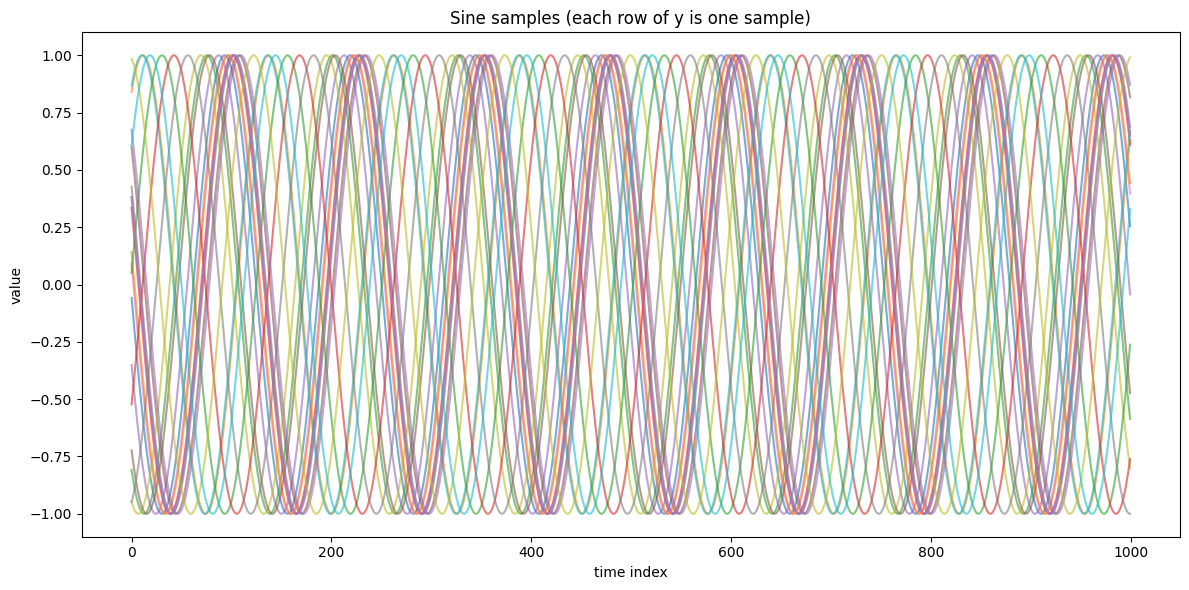

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# Choose how many samples to plot (limit for clarity)
num = min(20, y.shape[0])
show_legend = (num <= 10)
x_axis = np.arange(y.shape[1])
plt.figure(figsize=(12,6))
for i in range(num):
    plt.plot(x_axis, y[i], alpha=0.6, label=f'sample {i}')
plt.title('Sine samples (each row of y is one sample)')
plt.xlabel('time index')
plt.ylabel('value')
if show_legend:
    plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

In [4]:
import torch
y_t = torch.from_numpy(y).float()
print(y_t.size())
input_t = y_t.split(1, dim=1) # Returns a tuple of length L, each element is a tensor of shape (N, 1)
print(input_t[0].shape)  # should be (N, 1)

torch.Size([100, 1000])
torch.Size([100, 1])


In [5]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y_t:torch.Tensor, future_preds=0): # y_t needs to be a PyTorch tensor of shape (N, L)
        outputs = []
        n_samples = y_t.size(0) # number of samples in the batch N
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for input_t in y_t.split(1, dim=1): # Split along columns - dimension 1
            # input_t is a vector of length N
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [6]:
import torch.optim as optim

# y = (100, 1000)
# Split into training and test sets - first 3 samples for testing, rest for training
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999) - 0-998
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999) - 1-999

test_input = torch.from_numpy(y[:3, :-1]) # (3, 999) - 0-998
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999) - 1-999

model = LSTM()
loss = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08) # Using LBFGS optimiser instead of Adam

In [9]:
#8 epochs is usually enough to get good results
# If on future eopchs errors start to accumulate and predictions diverge several options are available:
# 1) Lower the number of model parameters i.e. size of hiddeb layer - possible down to 15
# 2) Downsample first cell output and/or second cell optput (reduce hidden layer size)
# 3) Add batchnorm regularisation that penalises large weights
# 4) Add dropout
# For the last two methods  need to call model.train() before training to turn on regularisation and model.eval() before testing to turn off regularisation

def training_loop(n_epochs, model:LSTM, optimiser: optim.Optimizer, loss_fn: nn.MSELoss, 
                  train_input:torch.Tensor, train_target:torch.Tensor, test_input:torch.Tensor, test_target:torch.Tensor):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss:torch.Tensor = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure) #Updates the parameters/weights

        # evaluate predictions on test data
        with torch.no_grad():
            future_preds = 1000
            pred:torch.Tensor = model(test_input, future_preds=future_preds)
            # use all pred samples, but only go to 999
            loss:torch.Tensor = loss_fn(pred[:, :-future_preds], test_target)
            y = pred.detach().numpy() #Detach from the computation graph and convert to numpy array
        
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future_preds), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out:torch.Tensor = model(train_input)
        loss_print:torch.Tensor = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [10]:
# Calling training loop
training_loop(n_epochs=9, model=model, optimiser=optimiser, loss_fn=loss,
              train_input=train_input, train_target=train_target, test_input=test_input, test_target=test_target)

Step: 0, Loss: 0.01657835580408573
Step: 1, Loss: 0.010430696420371532
Step: 2, Loss: 0.0015598206082358956
Step: 3, Loss: 0.0006822102004662156
Step: 4, Loss: 0.0003699381195474416
Step: 5, Loss: 0.00022957961482461542
Step: 6, Loss: 0.0001892630971269682
Step: 7, Loss: 0.0001372612314298749
Step: 8, Loss: 0.00011224618356209248
